In [538]:
from itertools import combinations

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [539]:
iris = load_iris(as_frame = True)

df = iris['data']
df.columns = ['s_length', 's_width', 'p_length', 'p_width']

full_df = df.copy()
full_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

df

,s_length,s_width,p_length,p_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Задание 1

<Axes: >

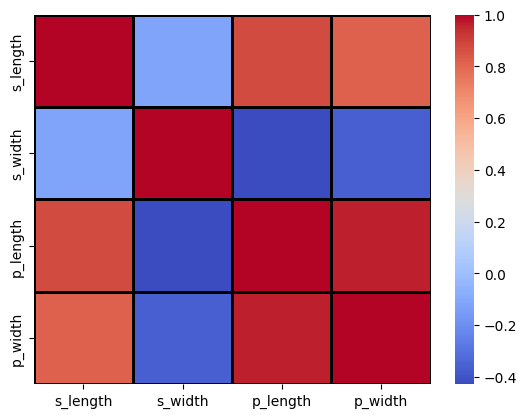

In [540]:
sns.heatmap(df.corr(), cmap = 'coolwarm', linewidths = 2, linecolor = 'black')

<Axes: ylabel='species-None'>

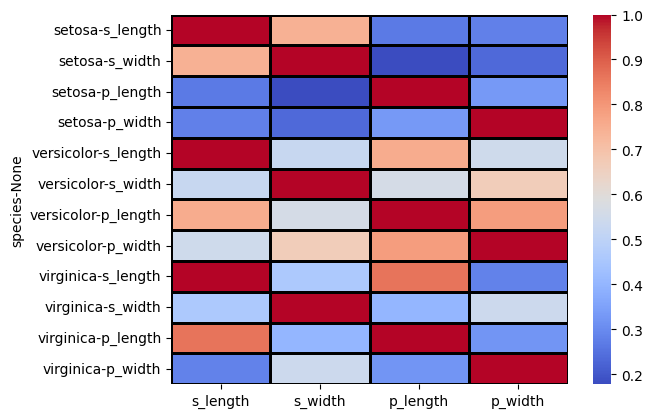

In [541]:
df_groups = df.groupby(full_df['species'], observed = True)
sns.heatmap(df_groups.corr(), cmap = 'coolwarm', linewidths = 2, linecolor = 'black')

In [542]:
def draw_pairplot(df, markers, palette):
    return sns.pairplot(df, hue = 'species', markers = markers, \
                 plot_kws = {'edgecolor' : 'black'}, palette = palette)

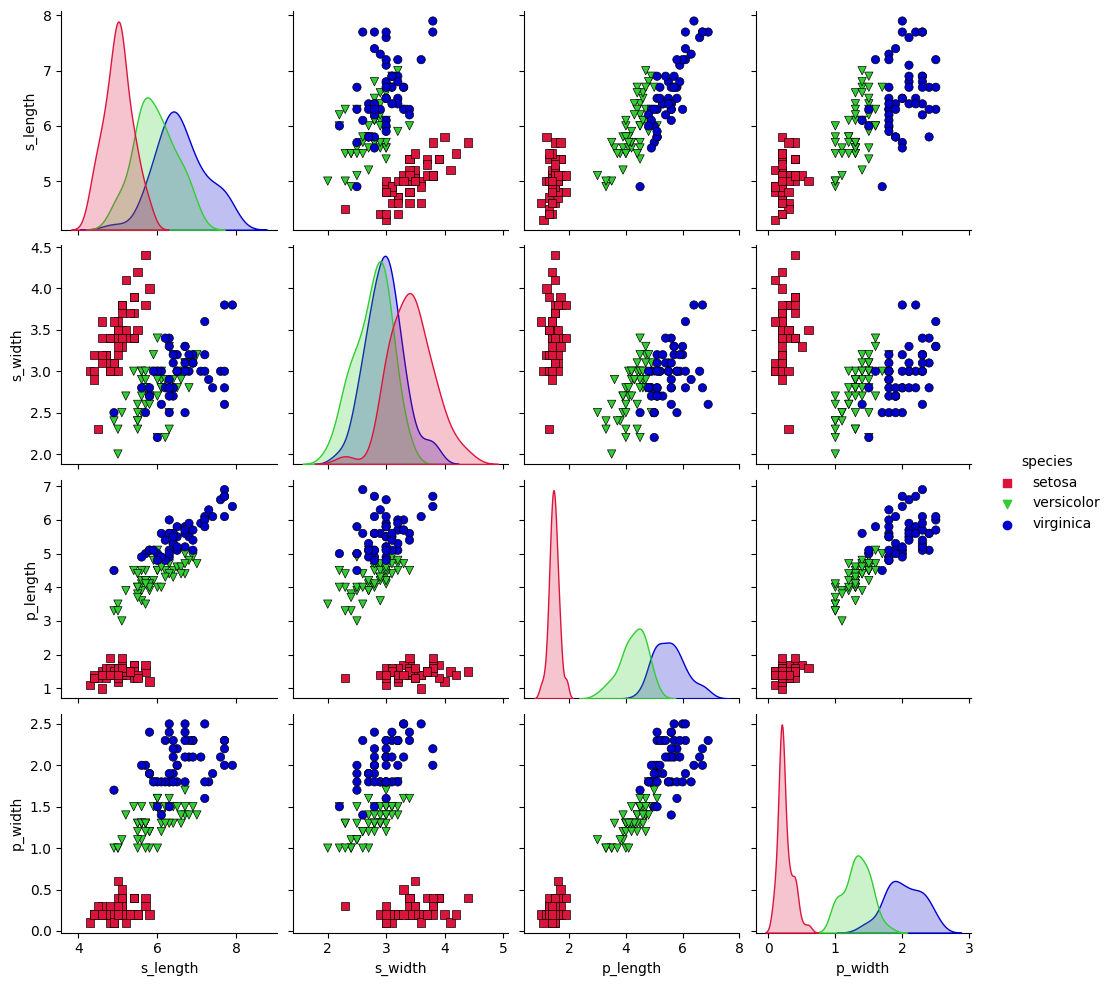

In [543]:
draw_pairplot(full_df, markers = ['s', 'v', 'o'], palette = ['#DC143C', '#32CD32', '#0000CD'])

## Задание 2

In [544]:
cols = np.random.permutation(df.columns.values)[:2]

In [545]:
def show_plot(estimator, cols, title):

    ax = plt.axes()

    DecisionBoundaryDisplay.from_estimator(estimator, 
                                           df[cols], 
                                           response_method = 'predict', 
                                           plot_method = 'pcolormesh', 
                                           ax = ax, 
                                           alpha = 0.5, 
                                           cmap = 'brg')

    for l, c, m in zip(iris.target.unique(), ['b','r','g'], ['s', 'v', 'o']):

        ax.scatter(df[cols[0]][iris.target == l], df[cols[1]][iris.target == l], \
                    c = c, marker = m, label = iris.target_names[l], edgecolors = 'black')

    plt.legend()
    plt.title(title)
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.show()

### LDA

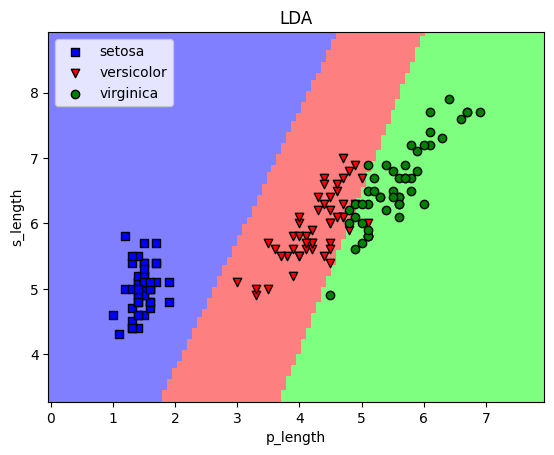

In [546]:
lda = LinearDiscriminantAnalysis().fit(df[cols], iris.target)
show_plot(lda, cols, 'LDA')

### QDA

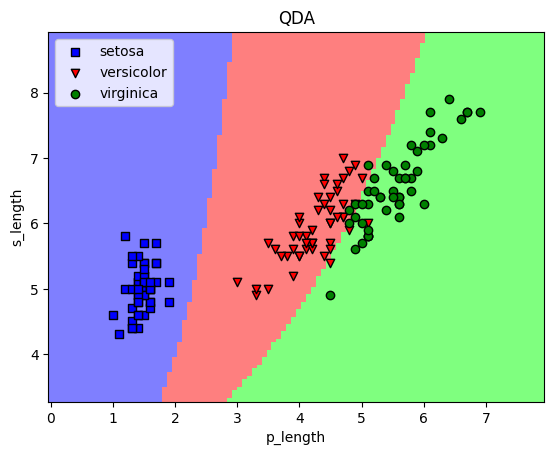

In [547]:
qda = QuadraticDiscriminantAnalysis().fit(df[cols], iris.target)
show_plot(qda, cols, 'QDA')

### Logistic regression

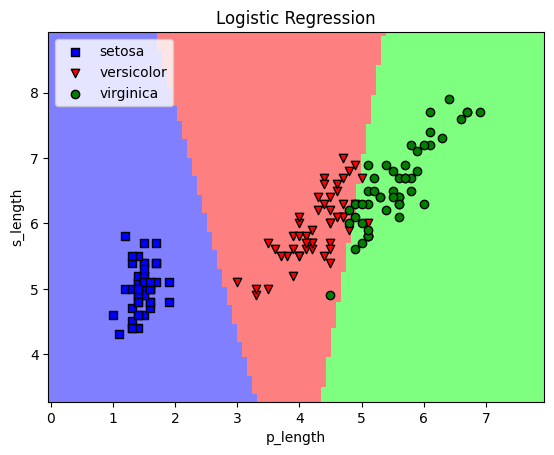

In [548]:
lr = LogisticRegression().fit(df[cols], iris.target)
show_plot(lr, cols, 'Logistic Regression')

### SVM (linear kernel)

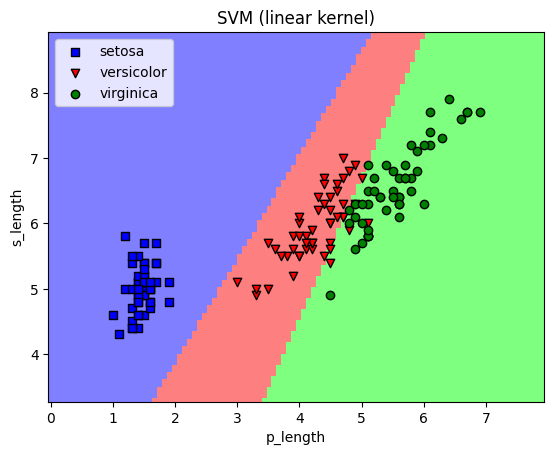

In [549]:
linSVC = svm.LinearSVC().fit(df[cols], iris.target)
show_plot(linSVC, cols, 'SVM (linear kernel)')

### SVM (quadratic kernel)

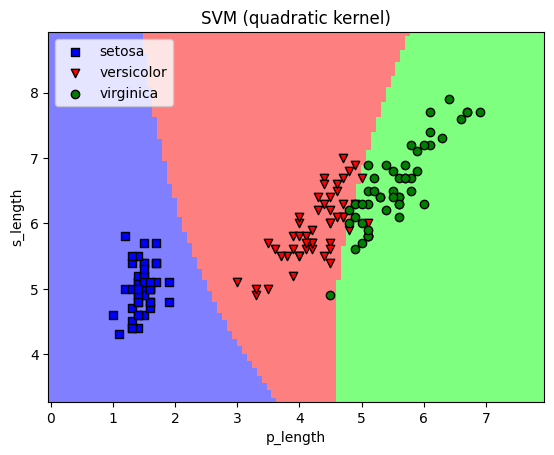

In [550]:
polySVC = svm.SVC(kernel = 'poly').fit(df[cols], iris.target)
show_plot(polySVC, cols, 'SVM (quadratic kernel)')

# Задание 3

In [551]:
X = df[full_df['species'] != 'virginica']
Y = iris.target[full_df['species'] != 'virginica']

In [552]:
def show_distrib(x, y, xlabel, ylabel):
    
    ax = plt.axes()

    for l, c, m in zip(iris.target.unique(), ['r','b'], ['s', 'o']):

        ax.scatter(x[iris.target == l], y[iris.target == l], \
            c = c, marker = m, label = iris.target_names[l], edgecolors = 'black')

    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return ax

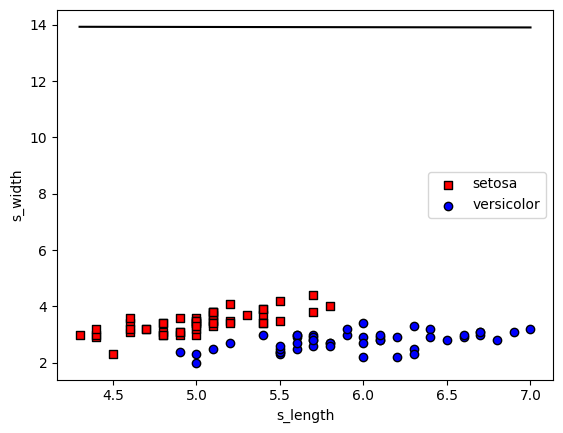

In [566]:
lda = LinearDiscriminantAnalysis().fit(X, Y)
cols = list(X.columns.values) 

col1 = 's_length'
col2 = 's_width'

ax = show_distrib(X[col1], X[col2], col1, col2)
x = np.array([X[col1].min(axis = 0), X[col1].max(axis = 0)])

coef = lda.coef_[0]

y = [(-coef[0]*X[:, 0].min() - lda.intercept_)/coef[1], 
          (-coef[0]*X[:, 0].max() - lda.intercept_)/coef[1]]
ax.plot(x, y, c = 'black')

plt.show()

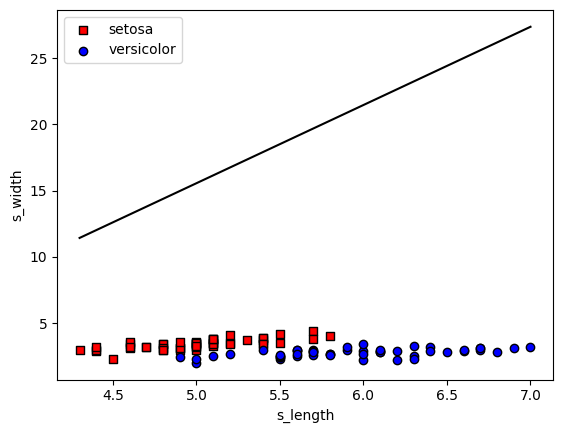

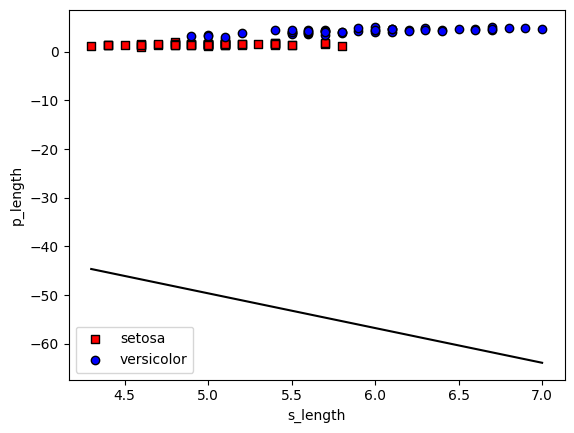

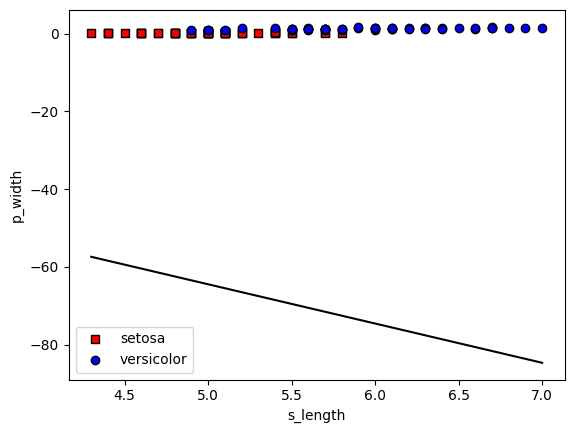

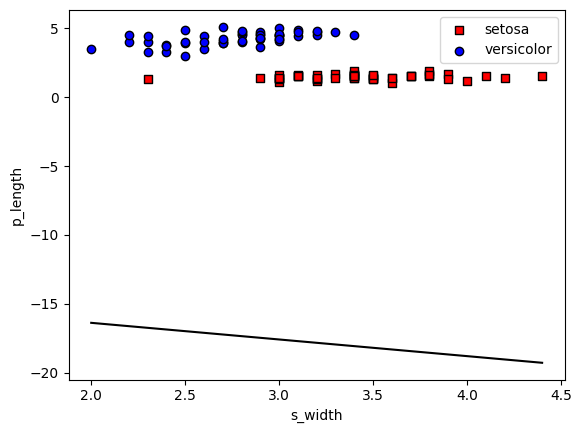

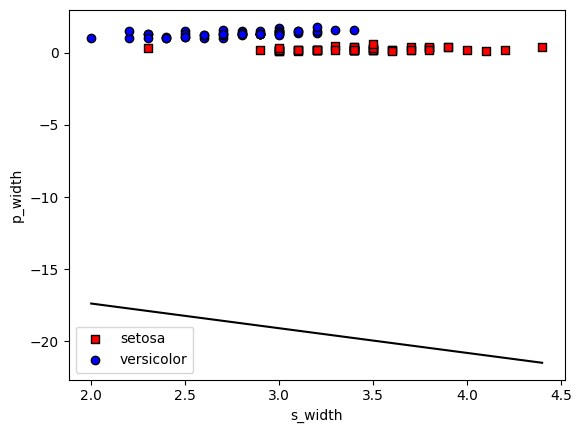

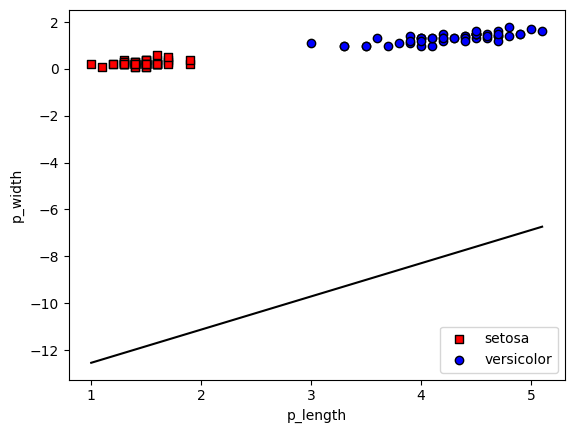

In [564]:
lda = LinearDiscriminantAnalysis().fit(X, Y)
cols = list(X.columns.values) 

for col1, col2 in combinations(cols, 2):       
    ax = show_distrib(X[col1], X[col2], col1, col2)

    x = np.array([X[col1].min(axis = 0), X[col1].max(axis = 0)])
    coefs = lda.coef_[0]
    b = lda.intercept_[0]

    w1, w2 = coefs[cols.index(col1)], coefs[cols.index(col2)]
    y = -(x * w2 / w1 + b)
    ax.plot(x, y, c = 'black')

    plt.show()